In [13]:
import os
import glob
import cv2
import tensorflow as tf

try:
    tf.config.set_visible_devices([], 'GPU')
    visible_devices = tf.config.get_visible_devices()
    for device in visible_devices:
        assert device.device_type != 'GPU'
except (AssertionError, ValueError, RuntimeError):
    raise RuntimeError('Unable to disable GPU')

    
import matplotlib.pyplot as plt
import glob
import numpy as np
import random

from PIL import Image

In [14]:
dim = 64

def read_img(file):
    img = tf.io.read_file(file)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, [dim, dim])
    img = img/127.5-1
    return img

In [15]:
def conv_model(num_blocks, rate, dim):
    
    input = tf.keras.layers.Input(shape=(dim,dim,3))
    
    x = tf.keras.layers.Conv2D(16, (16,16), strides=1)(input)
    x = tf.keras.layers.Dropout(rate)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
        
    for i in range(num_blocks-1):
        x = tf.keras.layers.Conv2D(8, (8,8), strides=1)(x)
        x = tf.keras.layers.Dropout(rate)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)
        
    x = tf.keras.layers.Conv2D(filters=2, kernel_size=1, strides=1)(x)
    x = tf.keras.layers.Dropout(rate)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.GlobalMaxPooling2D()(x)
    predictions = tf.keras.layers.Activation('softmax')(x)
    
    model = tf.keras.Model(inputs=input, outputs=predictions)
    print(model.summary())
    
    return model


In [16]:
num_blocks = 3
dropout = .1
model = conv_model(num_blocks,.1, dim)
model.load_weights('mask_classification_model_3_50.h5')
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 49, 49, 16)        12304     
_________________________________________________________________
dropout_16 (Dropout)         (None, 49, 49, 16)        0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 49, 49, 16)        64        
_________________________________________________________________
activation_16 (Activation)   (None, 49, 49, 16)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 42, 42, 8)         8200      
_________________________________________________________________
dropout_17 (Dropout)         (None, 42, 42, 8)         0   

In [48]:
def pred(img_path):
    im = read_img(img_path)
    vals = model.predict(np.expand_dims(im,axis=0))
    print(f"Mask Val: {vals[0][0]}, Non-mask Val: {vals[0][1]}")
    pred = np.argmax(vals,axis=1)
    print(f"Image predicted as {pred}")

pred('random_tests/biden.png')
pred('random_tests/trump.png')
pred('random_tests/hard.png')
pred('random_tests/face_face.png')



Mask Val: 0.6764245629310608, Non-mask Val: 0.3235754668712616
Image predicted as [0]
Mask Val: 0.0091919656842947, Non-mask Val: 0.9908080697059631
Image predicted as [1]
Mask Val: 0.9904122948646545, Non-mask Val: 0.009587661363184452
Image predicted as [0]
Mask Val: 0.10526204109191895, Non-mask Val: 0.8947380185127258
Image predicted as [1]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


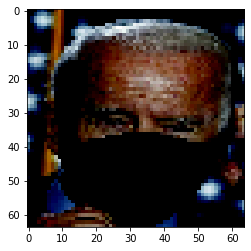